# Use Equilibrium Solver to Check Feasibility of having ozone and ammonia together in a deep atmosphere

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import copy
import pandas as pd
from scipy import optimize
from matplotlib import pyplot as plt
import pickle
from itertools import cycle
import matplotlib.colors as mcolors
import astropy.units as u
import astropy.constants as const

from photochem.utils import stars
import PICASO_Climate_grid_121625 as picaso_grid
import Photochem_grid_121625 as photochem_grid
import Reflected_Spectra_grid_13026 as Reflected_Spectra
from picaso.photochem import EquilibriumChemistry
import GraphsKey

import os
from pathlib import Path

current_directory = Path.cwd()
references_directory_path = "Installation&Setup_Instructions/picasofiles/reference"
PYSYN_directory_path = "Installation&Setup_Instructions/picasofiles/grp/redcat/trds"
print(os.path.join(current_directory, references_directory_path))
print(os.path.join(current_directory, PYSYN_directory_path))

os.environ['picaso_refdata']= os.path.join(current_directory, references_directory_path)
os.environ['PYSYN_CDBS']= os.path.join(current_directory, PYSYN_directory_path)


import picaso.justdoit as jdi
import picaso.justplotit as jpi

/mnt/c/Users/lily/Documents/NASAUWPostbac/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference
/mnt/c/Users/lily/Documents/NASAUWPostbac/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/grp/redcat/trds


In [5]:
import os

def Photochem_called(rad_plan=None, log10_planet_metallicity=None, tint=None, semi_major=None, ctoO=None, log_Kzz=None, PIC_PT=None):
    # Planet Parameters
    atoms_names = ['H', 'He', 'N', 'O', 'C'] # We select a subset of the atoms in zahnle_earth.yaml (leave out Cl), remove Sulpher for faster convergence

    # Calculate the Mass of the Planet and Teq
    mass_planet_earth = picaso_grid.mass_from_radius_chen_kipping_2017(R_rearth=rad_plan)
    mass_planet = mass_planet_earth * (5.972e+24) * 1e3 # of planet, but in grams
    radius_planet = rad_plan * (6.371e+6) * 1e2 # of planet but in cm
    solar_zenith_angle = 60 # Used in Tsai et. al. (2023), in degrees
    planet_Teq = picaso_grid.calc_Teq_SUN(distance_AU=semi_major)

    # Dependent constant variables
    if os.path.exists(f'sun_flux_file_{planet_Teq}'):
        stellar_flux_file = f'sun_flux_file_{planet_Teq}'
        print(f"The stellar flux file already exists")
    else:
        wv, F = star_spectrum.solar_spectrum(Teq=planet_Teq, outputfile= f'sun_flux_file_{planet_Teq}')
        stellar_flux_file = f'sun_flux_file_{planet_Teq}'

    pressure = PIC_PT['pressure']
    temperature = PIC_PT['temperature']
    PT_list = np.array([pressure, temperature]) 

    # Test Data - This works fine.
    #with open('out_Sun_5778_initp3bar.pkl', 'rb') as file:
    #    out_reopened = pickle.load(file)
    #    pressure = out_reopened['pressure']
    #    temperature = out_reopened['temperature']
    #PT_list = np.array(pressure), np.array(temperature)
    #convergence_values = np.array([1])

    # Define P-T Profile (convert from PICASO to Photochem)
    P_extended, T_extended = photochem_grid.linear_extrapolate_TP(PT_list[0], PT_list[1]) # Extend the end to bypass BOA Error of mismatching boundary conditions.
    #P = np.flip(np.array(PT_list[0]) * (10**6)).copy()
    #T = np.flip(np.array(PT_list[1])).copy()
    P = np.flip(np.array(P_extended) * (10**6)).copy() # Convert from bars to dynes/cm^2
    T = np.flip(np.array(T_extended)).copy()
    
    # Check if numpy array is sorted (investigating error)
    sorted_P = np.flip(np.sort(P)).copy()
    unsorted_indices = np.where(P != sorted_P)[0]
    
    # Generate reaction & thermodynamic files for gas giants
    photochem_grid.zahnle_rx_and_thermo_files(
    atoms_names=atoms_names,
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml',
    remove_reaction_particles=True # For gas giants, we should always leave out reaction particles.
    )

    # Initialize ExoAtmosphereGasGiant
    # Assigns 
    pc = photochem_grid.gasgiants.EvoAtmosphereGasGiant(
        mechanism_file='photochem_rxns.yaml',
        stellar_flux_file=stellar_flux_file,
        planet_mass=mass_planet,
        planet_radius=radius_planet,
        solar_zenith_angle=solar_zenith_angle,
        thermo_file='photochem_thermo.yaml'
    )
    # Adjust convergence parameters:
    pc.var.conv_longdy = 0.03 # converges at 3% (change of mixing ratios over long time)
    pc.gdat.max_total_step = 10000 # assumes convergence after 10,000 steps
    
    pc.gdat.verbose = True # printing
    
    # Define the host star composition
    molfracs_atoms_sun = np.ones(len(pc.gdat.gas.atoms_names))*1e-10 # This is for the Sun
    comp = {
        'H' : 9.21e-01,
        'N' : 6.23e-05,
        'O' : 4.51e-04,
        'C' : 2.48e-04,
        'S' : 1.21e-05,
        'He' : 7.84e-02
    }

    tot = sum(comp.values())
    for key in comp:
        comp[key] /= tot
    for i,atom in enumerate(pc.gdat.gas.atoms_names):
        molfracs_atoms_sun[i] = comp[atom]
    
    pc.gdat.gas.molfracs_atoms_sun = molfracs_atoms_sun

    # Assume a default radius for particles 1e-5cm was default, so we increased the size but think of these in microns
    particle_radius = pc.var.particle_radius
    particle_radius[:,:] = 1e-3 #cm or 10 microns
    pc.var.particle_radius = particle_radius

    # Assumed Kzz (cm^2/s) in Tsai et al. (2023)
    Kzz_zero_grid = np.ones(P.shape[0])
    Kzz = Kzz_zero_grid*(10**log_Kzz) #Note Kzz_fac was meant to be the power of 10 since we are in log10 space

    # Initialize the PT based on chemical equilibrium 
    pc.gdat.BOA_pressure_factor = 3
    pc.initialize_to_climate_equilibrium_PT(P, T, Kzz, 10**log10_planet_metallicity, ctoO)
    
    # Integrate to steady state
    converged = pc.find_steady_state()

    # Check if the model converged after 10,000 steps
    if not converged:
        assert pc.gdat.total_step_counter > pc.gdat.max_total_step - 10
        
    sol_raw = pc.return_atmosphere()
    soleq_raw = pc.return_atmosphere(equilibrium=True)

    # Call the interpolation of the grid 
    sol = photochem_grid.interpolate_photochem_result_to_nlayers(out=sol_raw, nlayers=100)
    soleq = photochem_grid.interpolate_photochem_result_to_nlayers(out=soleq_raw, nlayers=100)
    #convergence_values = np.array([convergence_values[0] for _ in range(len(sol['pressure']))])
    #converged = np.array([converged for _ in range(len(sol['pressure']))])

    # Print out the lengths of arrays: Save the size of the grid for future reference.

    print(f"This is for the input value of planet radius:{rad_plan}, metal:{float(log10_planet_metallicity)}, tint:{tint}, semi major:{semi_major}, ctoO: {ctoO}, log_Kzz: {log_Kzz}")
    
    #for key, value in sol.items():
    #    if isinstance(value, np.ndarray):  # Check if the value is a list (or array)
    #        print(f"The array for sol's '{key}' has a length of: {len(value)}")
    #    else:
    #        print(f"The value for sol's '{key}' is not an array.")

    #for key, value in soleq.items():
    #    if isinstance(value, np.ndarray):  # Check if the value is a list (or array)
    #        print(f"The array for soleq's '{key}' has a length of: {len(value)}, Length of pressure: {len(P)}")
    #    else:
    #        print(f"The value for soleq's '{key}' is not an array.")

    # Add nan's to fit the grid if underestimated, and make sure list goes from largest to smallest.
    

    return sol, soleq, pc

In [14]:
file_path = "/mnt/c/Users/lily/Documents/NASAUWPostbac/MiniNeptuneGrid26_PostBac/out_3.5m_0.01co.pkl"
with open(file_path, 'rb') as file:
    data_35m_001co = pickle.load(file)
    print(data_35m_001co.keys())
    print(data_35m_001co['converged'])
    print(data_35m_001co['cvz_locs'])

dict_keys(['pressure', 'temperature', 'ptchem_df', 'dtdp', 'cvz_locs', 'flux_ir_attop', 'fnet/fnetir', 'converged', 'flux_balance', 'all_profiles', 'all_opd', 'all_kzz', 'spectrum_output'])
1
[ 0 56 78 78 85 89]


In [6]:
rad_plan = 2.61
log10_metal = 3.5
tint = 155
semi_major = 1
ctoO = 0.01
Kzz = 5

sol_3000m_001co, soleq_3000m_001co, pc_3000m_001co = Photochem_called(rad_plan=rad_plan, log10_planet_metallicity=log10_metal, tint=tint, semi_major=semi_major, ctoO=ctoO, log_Kzz=Kzz, PIC_PT=data_35m_001co)

The stellar flux file already exists
nsteps = 100  longdy = 9.3e-01  max_dT = 3.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 4.7e-07
nsteps = 200  longdy = 9.5e-01  max_dT = 3.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 4.7e-07
nsteps = 300  longdy = 1.7e+00  max_dT = 3.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 4.8e-07
nsteps = 400  longdy = 3.4e+00  max_dT = 2.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 4.8e-07
nsteps = 500  longdy = 1.2e+00  max_dT = 2.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 4.8e-07
nsteps = 600  longdy = 1.9e+00  max_dT = 2.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 4.8e-07
nsteps = 700  longdy = 2.3e+00  max_dT = 2.7e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 5.0e-07
nsteps = 800  longdy = 2.5e+00  max_dT = 2.8e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 5.0e-07
nsteps = 900  longdy = 3.0e+00  max_dT = 2.8e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 5.0e-07
nsteps = 1000  longdy = 9.2e+00  max_dT = 2.8e+01  max_dlog10edd = 0.0e+00  TOA_p

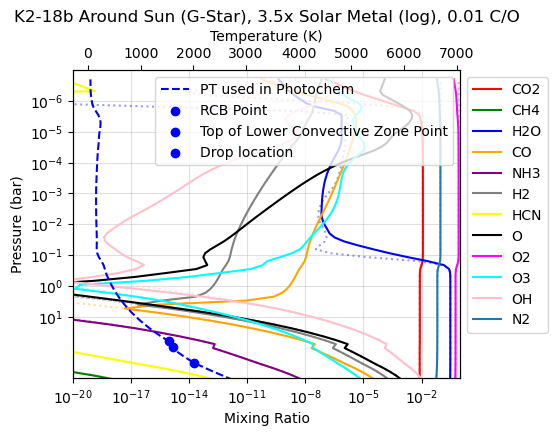

In [44]:
# This is the Photochemical Profile

custom_colors = ['red', 'green', 'blue', 'orange', 'purple', 'grey', 'yellow', 'black', 'magenta', 'cyan', 'pink', '#1f77b4']

# Plot the Composition from Photochem
fig, ax1 = plt.subplots(1,1,figsize=[5,4])
#species = ['CO2','H2O','CH4','CO','NH3','H2','HCN','H2Oaer']

species_sol = ['CO2','CH4','H2O','CO','NH3','H2','HCN', 'O', 'O2', 'O3', 'OH', 'N2']
species_soleq = ['CO2','CH4','H2O','CO','NH3','H2','HCN', 'O', 'O2', 'O3', 'OH', 'N2']
    
#for i,sp in enumerate(species):
#    ax1.plot(sol_dict[sp],sol_dict['pressure']/1e6,label=sp, c='C'+str(i))
#    ax1.plot(soleq_dict[sp],soleq_dict['pressure']/1e6, ls=':', c='C'+str(i), alpha=0.4)

index_soleq = 0
index_sol = 0

for i,sp in enumerate(species_soleq):
    ax1.plot(soleq_3000m_001co[sp],soleq_3000m_001co['pressure']/1e6, ls=':', c=custom_colors[index_soleq], alpha=0.4)
    index_soleq += 1
for i,sp in enumerate(species_sol):
    ax1.plot(sol_3000m_001co[sp],sol_3000m_001co['pressure']/1e6, c=custom_colors[index_sol], label=sp)
    index_sol +=1

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-20,1)
ax1.set_ylim(1000,1e-7)
ax1.grid(alpha=0.4)
ax1.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
ax1.set_xlabel('Mixing Ratio')
ax1.set_ylabel('Pressure (bar)')
ax1.set_yticks(10.0**np.arange(-6,2))
    
ax2 = ax1.twiny()
ax2.set_xlabel('Temperature (K)')

#ax2.set_xlim(0, 2500)
ax2.plot(sol_3000m_001co['temperature'], sol_3000m_001co['pressure']/10**6, c='blue', ls='--', label='PT used in Photochem')
ax2.scatter(1528.4941008619526, 63.09573444801943, c='blue', label='RCB Point')
ax2.scatter(2009.9039582806847, 316.2277660168379, c='blue', label='Top of Lower Convective Zone Point')
ax2.scatter(1615, 100, c='blue', label='Drop location')
#ax2.plot(np.flip(temperature_3000metal_1co[0][0][0][0][0]), np.flip(pressure_3000metal_1co[0][0][0][0][0]), c='black', ls='--',label='PT PICASO Profile')
    
plt.title('K2-18b Around Sun (G-Star), 3.5x Solar Metal (log), 0.01 C/O')
    
plt.legend()

plt.show()

### What is the Radiative Convective Boundary Layer?
This can be pulled from the output file of PICASO, specifically the 'cvz_locs' key. My guess is there are two radiative-convective layers; AI claims it is nstr[1] but I could argue otherwise.

Each value recorded represents the following (an index for the pressure associated with whether it is radiative/convective):
- nstr[0] = 0                    # Top layer [index 0]
- nstr[1] = X                    # Top layer of upper convective region
- nstr[2] = Y                    # Bottom layer of upper convective region
- nstr[3] = Z                    # Top layer of lower radiative region
- nstr[4] = A                    # Top layer of lower convective region
- nstr[5] = nlayer-1             # Bottom layer of lower convective region

In [30]:
file_path = "/mnt/c/Users/lily/Documents/NASAUWPostbac/MiniNeptuneGrid26_PostBac/out_3.5m_0.01co.pkl"
with open(file_path, 'rb') as file:
    data_35m_001co = pickle.load(file)
    print(data_35m_001co.keys())
    print(data_35m_001co['converged'])
    print(data_35m_001co['cvz_locs'])
    rad_conv_upper = data_35m_001co['cvz_locs'][2] # Bottom of upper convective region same as top of lower radiative region
    pressure_rcb = data_35m_001co['pressure'][rad_conv_upper]
    temperature_rcb = data_35m_001co['temperature'][rad_conv_upper]
    top_lower_rad = data_35m_001co['cvz_locs'][4]
    pres_toplow_rad = data_35m_001co['pressure'][top_lower_rad]
    temp_toplow_rad = data_35m_001co['temperature'][top_lower_rad]
    print(pressure_rcb, temperature_rcb)
    print(pres_toplow_rad, temp_toplow_rad)

dict_keys(['pressure', 'temperature', 'ptchem_df', 'dtdp', 'cvz_locs', 'flux_ir_attop', 'fnet/fnetir', 'converged', 'flux_balance', 'all_profiles', 'all_opd', 'all_kzz', 'spectrum_output'])
1
[ 0 56 78 78 85 89]
63.09573444801943 1528.4941008619526
316.2277660168379 2009.9039582806847
